In [1]:
from spineq.optimise import *
from spineq.plotting import *

import pandas as pd

In [2]:
weights = calc_oa_weights(population_weight=1,
                          workplace_weight=1,
                          pop_age_groups={
                            "total": {"min": 0, "max": 90, "weight": 1},
                            "children": {"min": 0, "max": 16, "weight": 0},
                            "elderly": {"min": 70, "max": 90, "weight": 0},
                          },
                          combine=False)

weights

,total,workplace
oa11cd,,
E00042044,0.000785,0.000260
E00042052,0.000996,0.000145
E00042054,0.000989,0.000115
E00042055,0.001056,0.000943
E00042058,0.000453,0.000151
...,...,...
E00042600,0.002684,0.001813
E00042873,0.001264,0.001076
E00042877,0.002541,0.000284


In [3]:
get_optimisation_inputs(population_weight=1,
                      workplace_weight=1,
                      pop_age_groups={
                            "total": {"min": 0, "max": 90, "weight": 1},
                            "children": {"min": 0, "max": 16, "weight": 1},
                            "elderly": {"min": 70, "max": 90, "weight":1},
                      },
                      combine=False)

{'oa11cd': array(['E00139797', 'E00139796', 'E00139703', 'E00139786', 'E00139704',
        'E00139821', 'E00042665', 'E00042671', 'E00042592', 'E00042812',
        'E00042661', 'E00175561', 'E00175595', 'E00042803', 'E00042411',
        'E00042490', 'E00042882', 'E00042160', 'E00042800', 'E00042881',
        'E00042161', 'E00042801', 'E00042880', 'E00042418', 'E00042499',
        'E00042419', 'E00042498', 'E00042168', 'E00042808', 'E00042169',
        'E00042888', 'E00042157', 'E00042154', 'E00042155', 'E00042152',
        'E00042153', 'E00042150', 'E00042151', 'E00042158', 'E00042159',
        'E00042666', 'E00042106', 'E00042187', 'E00042667', 'E00042107',
        'E00042186', 'E00042664', 'E00042104', 'E00042185', 'E00042184',
        'E00042662', 'E00042102', 'E00042183', 'E00042663', 'E00042103',
        'E00042182', 'E00042100', 'E00042101', 'E00042668', 'E00042108',
        'E00042189', 'E00042669', 'E00042109', 'E00042188', 'E00042656',
        'E00042657', 'E00042654', 'E00042

In [4]:
def greedy_single_obj(
    oa_x,
    oa_y,
    oa_weight,
    oa11cd,
    n_sensors=20,
    theta=500,
):
    n_poi = len(oa_x)

    # Compute coverage matrix: coverage at each OA due to a sensor placed at
    #  any other OA.
    coverage = coverage_matrix(oa_x, oa_y, theta=theta)

    # binary array - 1 if sensor at this location, 0 if not
    sensors = np.zeros(n_poi)

    # coverage obtained with each number of sensors
    placement_history = []
    coverage_history = []
    oa_coverage = []
    
    for s in range(n_sensors):
        # greedily add sensors
        print("Placing sensor", s + 1, "out of", n_sensors, "... ", end="")

        # initialise arrays to store best result so far
        best_total_coverage = 0
        best_sensors = sensors.copy()
        best_oa_coverage = sensors.copy()

        for site in range(n_poi):
            # try adding sensor at potential sensor site

            if sensors[site] == 1:
                # already have a sensor here, so skip to next
                continue

            else:
                new_sensors = sensors.copy()
                new_sensors[site] = 1

                # only keep coverages due to sites where a sensor is present
                mask_cov = np.multiply(coverage, new_sensors[np.newaxis, :])

                # coverage at each site = coverage due to nearest sensor
                max_mask_cov = np.max(mask_cov, axis=1)

                # Avg coverage = weighted sum across all points of interest
                new_coverage = (oa_weight * max_mask_cov).sum() / oa_weight.sum()

                if new_coverage > best_total_coverage:
                    # this site is the best site for next sensor found so far
                    best_new_site = oa11cd[site]
                    best_sensors = new_sensors.copy()
                    best_total_coverage = new_coverage
                    best_oa_coverage = max_mask_cov

        sensors = best_sensors.copy()
        placement_history.append(best_new_site)
        coverage_history.append(best_total_coverage)
        oa_coverage = best_oa_coverage.copy()

        print("coverage = {:.2f}".format(best_total_coverage))
        
    result = make_result_dict(
        n_sensors,
        theta,
        oa_x,
        oa_y,
        oa11cd,
        sensors,
        best_total_coverage,
        oa_coverage,
        placement_history,
        coverage_history,
        oa_weight=oa_weight,
    )

    return result

In [5]:
data = get_optimisation_inputs(population_weight=1,
                               workplace_weight=1,
                               pop_age_groups={
                                        "pop_total": {"min": 0, "max": 90, "weight": 1},
                                        "pop_children": {"min": 0, "max": 16, "weight": 1},
                                        "pop_elderly": {"min": 70, "max": 90, "weight": 1},
                                  },
                               combine=False)

oa_x = data["oa_x"]
oa_y = data["oa_y"]
oa_weight = data["oa_weight"]
oa11cd = data["oa11cd"]

n_sensors = 20
theta = 250

if type(oa_weight) is dict:
    print("Number of Objectives:", len(oa_weight))
    results = {}
    for name, weights in oa_weight.items():
        print("="*30)
        print("Doing", name)
        print("="*30)
        results[name] = greedy_single_obj(
            oa_x,
            oa_y,
            weights,
            oa11cd,
            n_sensors=n_sensors,
            theta=theta
        )

else:
    result = greedy_single_obj(
        oa_x,
        oa_y,
        oa_weight,
        oa11cd,
        n_sensors=n_sensors,
        theta=theta
    )
     

Number of Objectives: 4
Doing pop_total
Placing sensor 1 out of 20 ... coverage = 0.02
Placing sensor 2 out of 20 ... coverage = 0.04
Placing sensor 3 out of 20 ... coverage = 0.05
Placing sensor 4 out of 20 ... coverage = 0.06
Placing sensor 5 out of 20 ... coverage = 0.07
Placing sensor 6 out of 20 ... coverage = 0.08
Placing sensor 7 out of 20 ... coverage = 0.09
Placing sensor 8 out of 20 ... coverage = 0.10
Placing sensor 9 out of 20 ... coverage = 0.11
Placing sensor 10 out of 20 ... coverage = 0.11
Placing sensor 11 out of 20 ... coverage = 0.12
Placing sensor 12 out of 20 ... coverage = 0.13
Placing sensor 13 out of 20 ... coverage = 0.13
Placing sensor 14 out of 20 ... coverage = 0.14
Placing sensor 15 out of 20 ... coverage = 0.15
Placing sensor 16 out of 20 ... coverage = 0.15
Placing sensor 17 out of 20 ... coverage = 0.16
Placing sensor 18 out of 20 ... coverage = 0.17
Placing sensor 19 out of 20 ... coverage = 0.17
Placing sensor 20 out of 20 ... coverage = 0.18
Doing pop

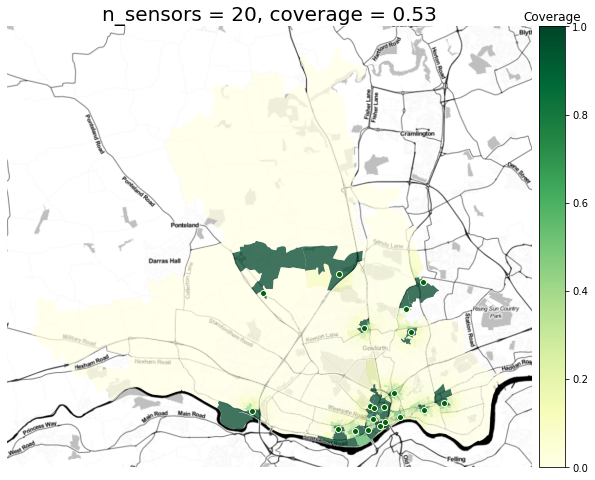

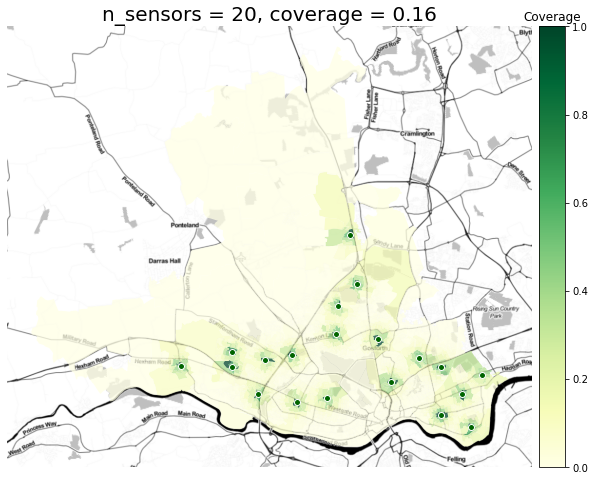

In [7]:
plot_optimisation_result(results["workplace"])
plot_optimisation_result(results["pop_elderly"])

In [12]:
sensors_per_objective = {
    "workplace": 5,
    "pop_total": 5,
    "pop_children": 5,
    "pop_elderly": 5
}

chosen_oa = []

for name, result in results.items():
    print(name,":", result["placement_history"][:sensors_per_objective[name]])
    top_oa = result["placement_history"][:sensors_per_objective[name]]
    for oa in top_oa:
        if oa not in chosen_oa:
            chosen_oa.append(oa)

print("="*50)
print("NETWORK:")
print(chosen_oa)
print(len(chosen_oa))

pop_total : ['E00042820', 'E00042672', 'E00042262', 'E00042447', 'E00042433']
pop_children : ['E00042262', 'E00042608', 'E00175591', 'E00042888', 'E00042570']
pop_elderly : ['E00042846', 'E00042713', 'E00042228', 'E00042417', 'E00042174']
workplace : ['E00042580', 'E00175551', 'E00042371', 'E00175577', 'E00042583']
NETWORK:
['E00042820', 'E00042672', 'E00042262', 'E00042447', 'E00042433', 'E00042608', 'E00175591', 'E00042888', 'E00042570', 'E00042846', 'E00042713', 'E00042228', 'E00042417', 'E00042174', 'E00042580', 'E00175551', 'E00042371', 'E00175577', 'E00042583']
19


In [10]:
results.keys()

dict_keys(['pop_total', 'pop_children', 'pop_elderly', 'workplace'])